## Fluxo de Trabalho em Machine Learning: Do Tratamento dos Dados à Interpretação de Resultados

![texto alternativo](images/1.png)

## Problema de Negócio:

A mineradora é especializada na produção e comercialização de diferentes tipos de produto, e está enfrentando desafios no gerenciamento de seu estoque de produtos. A demanda por esses produtos pode variar de acordo com fatores sazonais, projetos de construção, condições econômicas e clima, o que pode levar a falta de estoque ou excesso de produção.

## Precisamos Entender:

* A motivação (Qual o contexto)
* A causa raiz do problema (Porque fazer uma previsão da quantidade de produtos vendidos?)
* Quem é o dono do problema?
* O formato da solução (Granularidade, Tipo do problema, Metodos e Formato da entrega)

## Método CRISP (Gerenciamento de projetos)

* Método Cíclico de desenvolvimento

1 - Ciclo CRISP Completo:

* 1 Versão end-to-end da solução
* Velocidade na entrega de valor
* Mapeamento de todos os possiveis problemas

#### CRISP
![texto alternativo](images/2.png)


# 0.0. IMPORTS

In [64]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import re
import unicodedata
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suprimir avisos de FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

## 0.2. Loading data

In [2]:
# Lista de colunas a serem excluídas
columns_to_exclude = ['Preço', 'Desconto', 'PIS_Valor', 'COFINS_Valor', 'NFCe_vICMSDeson', 'ValorEntrada']  # Substitua pelos nomes das colunas que deseja excluir

# Carrega o CSV excluindo as colunas
df_sales_filtered = pd.read_csv('data/df_filtrado.csv', usecols=lambda col: col not in columns_to_exclude, low_memory=False)

# Verifica o DataFrame resultante
df_sales_filtered.head()

,Código da Venda,Código da Mercadoria,Quantidade,Produto,TipoGrupo,Data da Venda,Nome do Cliente,Vendedor,FormaEntrada,Parcelado,LojaOrigem
0,3530,3,"35,08",BRITA 19MM,MINÉRIOS DE GRANITO,2023-07-13 00:00:00.000,267,11,NaN,0,BURITI
1,3539,12,1,TAXA CARTÃO,MINÉRIOS DE GRANITO,2023-07-13 00:00:00.000,267,11,NaN,0,BURITI
2,3,11,1,GNRE,MINÉRIOS DE GRANITO,2023-03-01 00:00:00.000,2,10,NaN,0,BURITI
3,3,10,1,FRETE,MINÉRIOS DE GRANITO,2023-03-01 00:00:00.000,2,10,NaN,0,BURITI
4,3,4,"6,71","BRITA 12,5MM",MINÉRIOS DE GRANITO,2023-03-01 00:00:00.000,2,10,NaN,0,BURITI


# 1.0. DESCRICAO DOS DADOS

**O quão desafiador é o problema?**

* **Quantidade de dados:** Eu tenho recursos corretos para trabalhar?
* **Tipos de variaveis:** Estou trabalhando com quais tipos de variaveis? numericas? categoricas?...
* **Quantidade de dados faltantes:** Qual o volume? Qual a razação da falta de dados? Sistema? Manual?
* **Resumo Geral dos dados:** Estatistica descritivas

In [3]:
df1 = df_sales_filtered.copy()

## 1.1. Rename Columns

In [4]:
df1.columns

Index(['Código da Venda', 'Código da Mercadoria', 'Quantidade', 'Produto',
       'TipoGrupo', 'Data da Venda', 'Nome do Cliente', 'Vendedor',
       'FormaEntrada', 'Parcelado', 'LojaOrigem'],
      dtype='object')

In [5]:
# Função para remover acentos e aplicar snake_case
def to_snake_case_custom(col):
    # Remover acentos
    col = ''.join(
        char for char in unicodedata.normalize('NFD', col)
        if unicodedata.category(char) != 'Mn'
    )
    # Adicionar underscore entre letras minúsculas e maiúsculas se necessário
    col = re.sub(r'([a-z])([A-Z])', r'\1_\2', col)
    # Converter para snake_case
    col = col.lower().replace(' ', '_')
    return col

# Lista de colunas antigas do DataFrame
cols_old = df1.columns

# Aplicar a função customizada para modificar os nomes das colunas
cols_new = list(map(to_snake_case_custom, cols_old))

# Atribuir os novos nomes das colunas ao DataFrame
df1.columns = cols_new

# Verificar o resultado
df1.columns

Index(['codigo_da_venda', 'codigo_da_mercadoria', 'quantidade', 'produto',
       'tipo_grupo', 'data_da_venda', 'nome_do_cliente', 'vendedor',
       'forma_entrada', 'parcelado', 'loja_origem'],
      dtype='object')

## 1.2. Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 15492
Number of Cols: 11


## 1.3. Data Types

In [7]:
df1.dtypes

codigo_da_venda           int64
codigo_da_mercadoria      int64
quantidade               object
produto                  object
tipo_grupo               object
data_da_venda            object
nome_do_cliente           int64
vendedor                  int64
forma_entrada           float64
parcelado                 int64
loja_origem              object
dtype: object

In [8]:
# Substituir vírgulas por pontos e remover espaços em branco
df1['quantidade'] = df1['quantidade'].str.replace(',', '.').str.strip()

# Converter a coluna para float64
df1['quantidade'] = df1['quantidade'].astype('float64')

# Converter a coluna para datetime
df1['data_da_venda'] = pd.to_datetime( df1['data_da_venda'] )

In [9]:
df1.dtypes

codigo_da_venda                  int64
codigo_da_mercadoria             int64
quantidade                     float64
produto                         object
tipo_grupo                      object
data_da_venda           datetime64[ns]
nome_do_cliente                  int64
vendedor                         int64
forma_entrada                  float64
parcelado                        int64
loja_origem                     object
dtype: object

In [10]:
df1.head()

,codigo_da_venda,codigo_da_mercadoria,quantidade,produto,tipo_grupo,data_da_venda,nome_do_cliente,vendedor,forma_entrada,parcelado,loja_origem
0,3530,3,35.08,BRITA 19MM,MINÉRIOS DE GRANITO,2023-07-13,267,11,NaN,0,BURITI
1,3539,12,1.00,TAXA CARTÃO,MINÉRIOS DE GRANITO,2023-07-13,267,11,NaN,0,BURITI
2,3,11,1.00,GNRE,MINÉRIOS DE GRANITO,2023-03-01,2,10,NaN,0,BURITI
3,3,10,1.00,FRETE,MINÉRIOS DE GRANITO,2023-03-01,2,10,NaN,0,BURITI
4,3,4,6.71,"BRITA 12,5MM",MINÉRIOS DE GRANITO,2023-03-01,2,10,NaN,0,BURITI


## 1.4. Check NA

In [11]:
df1.isna().sum()

codigo_da_venda             0
codigo_da_mercadoria        0
quantidade                  0
produto                     0
tipo_grupo                  0
data_da_venda               0
nome_do_cliente             0
vendedor                    0
forma_entrada           15492
parcelado                   0
loja_origem                 0
dtype: int64

In [12]:
# Remover a coluna 'forma_entrada'
df1 = df1.drop(columns=['forma_entrada'])

In [13]:
df1.head()

,codigo_da_venda,codigo_da_mercadoria,quantidade,produto,tipo_grupo,data_da_venda,nome_do_cliente,vendedor,parcelado,loja_origem
0,3530,3,35.08,BRITA 19MM,MINÉRIOS DE GRANITO,2023-07-13,267,11,0,BURITI
1,3539,12,1.00,TAXA CARTÃO,MINÉRIOS DE GRANITO,2023-07-13,267,11,0,BURITI
2,3,11,1.00,GNRE,MINÉRIOS DE GRANITO,2023-03-01,2,10,0,BURITI
3,3,10,1.00,FRETE,MINÉRIOS DE GRANITO,2023-03-01,2,10,0,BURITI
4,3,4,6.71,"BRITA 12,5MM",MINÉRIOS DE GRANITO,2023-03-01,2,10,0,BURITI


In [14]:
df1.isna().sum()

codigo_da_venda         0
codigo_da_mercadoria    0
quantidade              0
produto                 0
tipo_grupo              0
data_da_venda           0
nome_do_cliente         0
vendedor                0
parcelado               0
loja_origem             0
dtype: int64

## 1.5. Correção

In [15]:
# Mostrar os dados únicos da coluna 'produto'
unique_produtos = df1['produto'].unique()

# Exibir os dados únicos
print(unique_produtos)

['BRITA 19MM' 'TAXA CARTÃO' 'GNRE' 'FRETE' 'BRITA 12,5MM' 'BRITA CORRIDA'
 'PÓ DE BRITA' 'ACRESCIMOS' 'BRITA 9,5MM' 'BRITA 25MM' 'ENTREGA'
 'PO DE BRITA' 'BRITA 1/2 (12,7mm)' 'CBUQ TESTE']


In [16]:
# Remover as linhas com valores indesejados na coluna 'produto'
df1 = df1[~df1['produto'].isin(['CBUQ TESTE', 'GNRE', 'FRETE', 'ENTREGA', 'TAXA CARTÃO', 'ACRESCIMOS'])]

# Substituir 'PÓ DE BRITA' por 'PO DE BRITA'
df1['produto'] = df1['produto'].replace('PÓ DE BRITA', 'PO DE BRITA')

# Verificar as alterações
print(df1['produto'].unique())

['BRITA 19MM' 'BRITA 12,5MM' 'BRITA CORRIDA' 'PO DE BRITA' 'BRITA 9,5MM'
 'BRITA 25MM' 'BRITA 1/2 (12,7mm)']


In [17]:
# Contar a quantidade de linhas nos DataFrames
linhas_df_sales_filtered = len(df_sales_filtered)  # Certifique-se de recriar df_sales_filtered
linhas_df1 = len(df1)

print(f"Linhas em df_sales_filtered: {linhas_df_sales_filtered}")
print(f"Linhas em df1: {linhas_df1}")

Linhas em df_sales_filtered: 15492
Linhas em df1: 12479


In [18]:
df1.head()

,codigo_da_venda,codigo_da_mercadoria,quantidade,produto,tipo_grupo,data_da_venda,nome_do_cliente,vendedor,parcelado,loja_origem
0,3530,3,35.08,BRITA 19MM,MINÉRIOS DE GRANITO,2023-07-13,267,11,0,BURITI
4,3,4,6.71,"BRITA 12,5MM",MINÉRIOS DE GRANITO,2023-03-01,2,10,0,BURITI
5,4,9,51.00,BRITA CORRIDA,MINÉRIOS DE GRANITO,2023-03-06,1,11,0,BURITI
8,6,3,5.00,BRITA 19MM,MINÉRIOS DE GRANITO,2023-03-09,687,11,0,BURITI
9,8,4,1.00,"BRITA 12,5MM",MINÉRIOS DE GRANITO,2023-03-09,1407,13,0,BURITI


## 1.6. Descriptive Statistics

In [19]:
df1.dtypes

codigo_da_venda                  int64
codigo_da_mercadoria             int64
quantidade                     float64
produto                         object
tipo_grupo                      object
data_da_venda           datetime64[ns]
nome_do_cliente                  int64
vendedor                         int64
parcelado                        int64
loja_origem                     object
dtype: object

In [20]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.6.1. Numerical Atributes

In [21]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']

In [22]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,codigo_da_venda,3.0000,16838.000,16835.0000,8896.183108,10213.00,5071.947469,-0.217609,-1.254368
1,codigo_da_mercadoria,1.0000,1044.000,1043.0000,3.008975,3.00,9.409043,108.535650,12008.586906
2,quantidade,0.0052,146.208,146.2028,14.299611,12.95,8.599437,2.360952,13.268826
3,nome_do_cliente,1.0000,2050.000,2049.0000,971.453883,1116.00,680.894027,-0.093566,-1.580054
4,vendedor,3.0000,19.000,16.0000,11.255870,11.00,1.427243,2.188250,12.905283
5,parcelado,0.0000,0.000,0.0000,0.000000,0.00,0.000000,0.000000,0.000000


###  1.6.2. Categorical Atributes

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

produto        7
tipo_grupo     2
loja_origem    1
dtype: int64

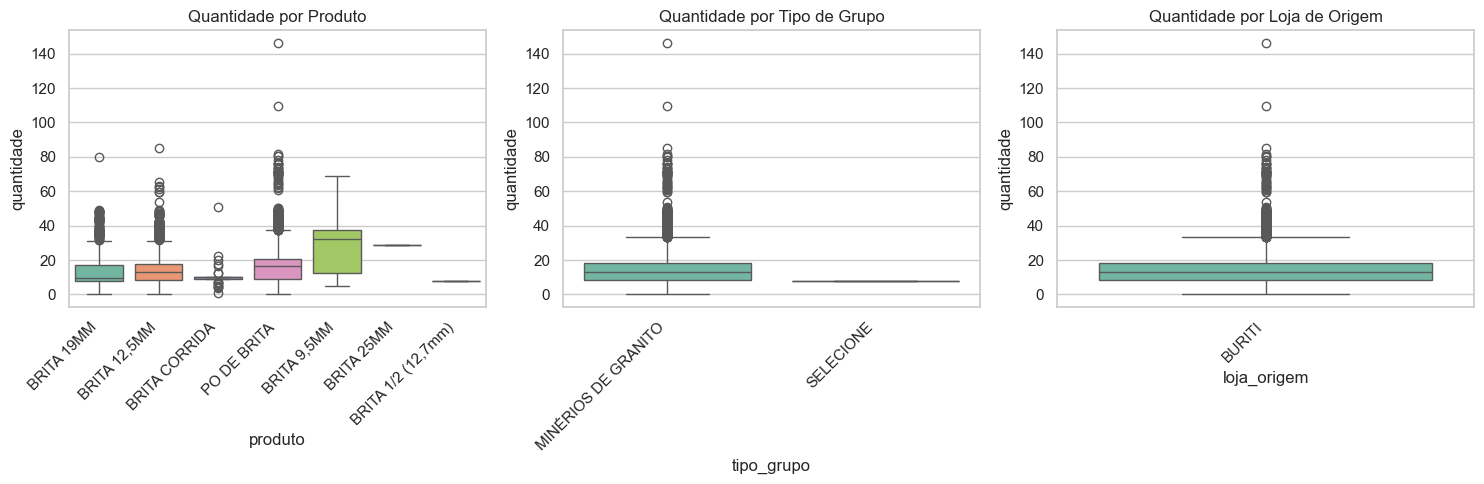

In [24]:
# Definir o estilo do gráfico
sns.set(style="whitegrid")

# Definir o tamanho da figura
plt.figure(figsize=(15, 5))

# Filtrar os dados
aux = df1[(df1['produto'] != '0') & (df1['quantidade'] > 0)]

# Gráfico 1: Boxplot de 'produto' vs 'quantidade'
plt.subplot(1, 3, 1)
sns.boxplot(x='produto', y='quantidade', data=aux, palette='Set2')
plt.xticks(rotation=45, ha='right')  # Rotacionar os labels para melhor visualização
plt.title('Quantidade por Produto')

# Gráfico 2: Boxplot de 'tipo_grupo' vs 'quantidade'
plt.subplot(1, 3, 2)
sns.boxplot(x='tipo_grupo', y='quantidade', data=aux, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Quantidade por Tipo de Grupo')

# Gráfico 3: Boxplot de 'loja_origem' vs 'quantidade'
plt.subplot(1, 3, 3)
sns.boxplot(x='loja_origem', y='quantidade', data=aux, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Quantidade por Loja de Origem')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()


In [25]:
# Remover as colunas 'tipo_grupo' e 'loja_origem'
df1 = df1.drop(columns=['tipo_grupo', 'loja_origem'])

In [26]:
df1.head()

,codigo_da_venda,codigo_da_mercadoria,quantidade,produto,data_da_venda,nome_do_cliente,vendedor,parcelado
0,3530,3,35.08,BRITA 19MM,2023-07-13,267,11,0
4,3,4,6.71,"BRITA 12,5MM",2023-03-01,2,10,0
5,4,9,51.00,BRITA CORRIDA,2023-03-06,1,11,0
8,6,3,5.00,BRITA 19MM,2023-03-09,687,11,0
9,8,4,1.00,"BRITA 12,5MM",2023-03-09,1407,13,0


# 2.0. FEATURE ENGINEERING

**Mapa Mental de Hipóteses.**

* Fenômeno: Qual o fenomeno estou modelando?
* Agentes: Quem são os agentes que atuam no fenomeno de interesse?
* Atributos dos agentes: Qual a descrição dos agentes?
* Lista de Hipoteses: Hipoteses para validar com os dados

In [27]:
df2 = df1.copy()

# 3.0. FILTRAGEM DE VARIÁVEIS

**Restrições de acordo com o negocio**

**Variaveis mais relevantes para o modelo**

In [28]:
df3 = df2.copy()

##  3.1. Filtragem das Linhas

## 3.2. Selecao das Colunas

In [29]:
# Remover as colunas 'tipo_grupo' e 'loja_origem'
df3 = df3.drop(columns=['codigo_da_venda', 'codigo_da_mercadoria', 'nome_do_cliente', 'vendedor', 'parcelado'])

In [30]:
df3.head()

,quantidade,produto,data_da_venda
0,35.08,BRITA 19MM,2023-07-13
4,6.71,"BRITA 12,5MM",2023-03-01
5,51.00,BRITA CORRIDA,2023-03-06
8,5.00,BRITA 19MM,2023-03-09
9,1.00,"BRITA 12,5MM",2023-03-09


# 4.0. ANALISE EXPLORATORIA DOS DADOS

**Como as variaveis impactam o fenomeno?**

**Qual a força desse impacto**

**Objetivos**

* Ganhar experiencia de negocio
* Validar hipoteses de negocio
* Perceber variaveis que são importantes para o modelo

In [31]:
df4 = df3.copy()

###  Distribuição de Produtos

In [32]:
# Contagem de vendas por produto
print(df4['produto'].value_counts())

# Quantidade total vendida por produto
quantidade_por_produto = df4.groupby('produto')['quantidade'].sum()
print(quantidade_por_produto)

produto
BRITA 12,5MM          5570
PO DE BRITA           3423
BRITA 19MM            3404
BRITA CORRIDA           47
BRITA 9,5MM             33
BRITA 25MM               1
BRITA 1/2 (12,7mm)       1
Name: count, dtype: int64
produto
BRITA 1/2 (12,7mm)        8.010000
BRITA 12,5MM          74949.414616
BRITA 19MM            43550.923459
BRITA 25MM               28.800000
BRITA 9,5MM             868.695508
BRITA CORRIDA           499.441000
PO DE BRITA           58539.560119
Name: quantidade, dtype: float64


In [33]:
# Filtrar o DataFrame para o produto 'BRITA 25MM'
produto_filtrado_25mm = df4[df4['produto'] == 'BRITA 25MM']
print(produto_filtrado_25mm[['produto', 'data_da_venda']])

# Filtrar o DataFrame para o produto 'BRITA 1/2 (12,7mm)'
produto_filtrado_12mm = df4[df4['produto'] == 'BRITA 1/2 (12,7mm)']
print(produto_filtrado_12mm[['produto', 'data_da_venda']])


        produto data_da_venda
323  BRITA 25MM    2023-03-22
                 produto data_da_venda
6544  BRITA 1/2 (12,7mm)    2023-11-16


### Análise de Séries Temporais

In [34]:
# Agrupar por 'data_da_venda' e 'produto' e somar a 'quantidade' vendida
df_grouped = df4.groupby(['data_da_venda', 'produto']).sum().reset_index()

# Verificar o resultado para garantir que os produtos não estão concatenados
print(df_grouped)

     data_da_venda        produto  quantidade
0       2023-03-01   BRITA 12,5MM      6.7100
1       2023-03-06  BRITA CORRIDA     51.0000
2       2023-03-09   BRITA 12,5MM    174.0540
3       2023-03-09     BRITA 19MM     80.8800
4       2023-03-09    PO DE BRITA    148.5931
...            ...            ...         ...
1278    2024-07-30   BRITA 12,5MM    213.2670
1279    2024-07-30     BRITA 19MM    120.0200
1280    2024-07-30    PO DE BRITA    181.7300
1281    2024-07-31   BRITA 12,5MM     32.9400
1282    2024-07-31     BRITA 19MM      8.9300

[1283 rows x 3 columns]


produto
BRITA 12,5MM          74949.414616
PO DE BRITA           58539.560119
BRITA 19MM            43550.923459
BRITA 9,5MM             868.695508
BRITA CORRIDA           499.441000
BRITA 25MM               28.800000
BRITA 1/2 (12,7mm)        8.010000
Name: quantidade, dtype: float64


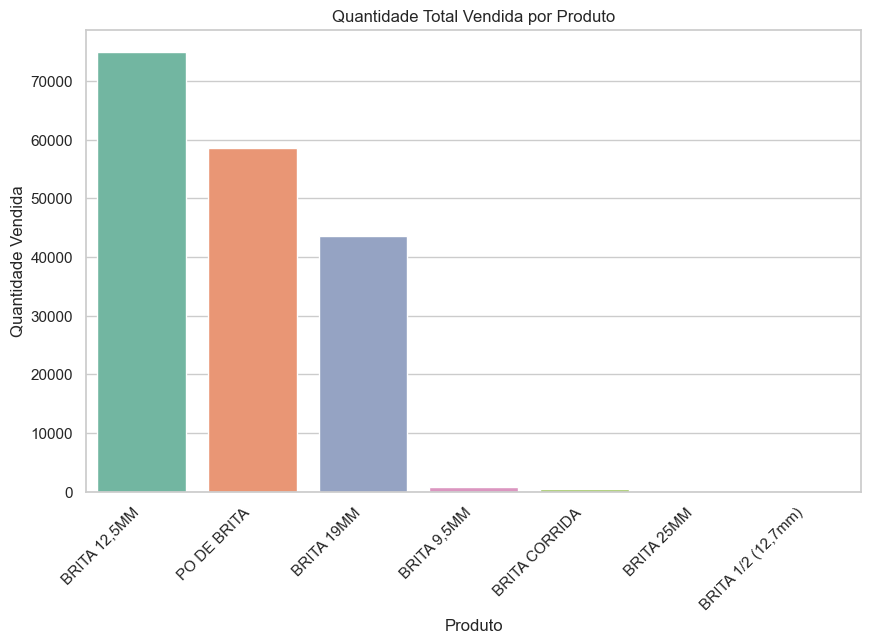

In [35]:
# Somar a quantidade vendida por produto
vendas_por_produto = df_grouped.groupby('produto')['quantidade'].sum().sort_values(ascending=False)

# Exibir o resultado
print(vendas_por_produto)

# Plotar um gráfico de barras das vendas por produto
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=vendas_por_produto.index, y=vendas_por_produto.values, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Quantidade Total Vendida por Produto')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Produto')
plt.show()

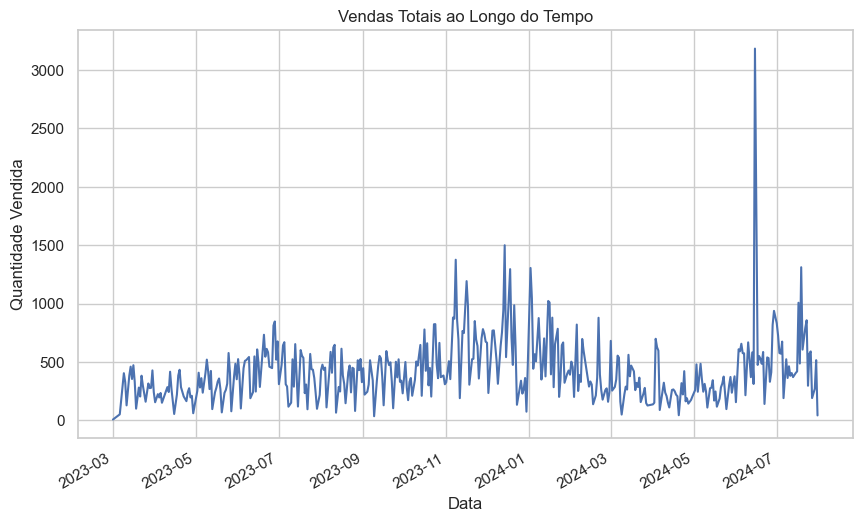

In [36]:
# Agrupar as vendas por data e somar as quantidades
vendas_por_data = df_grouped.groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas totais ao longo do tempo
plt.figure(figsize=(10, 6))
vendas_por_data.plot()
plt.title('Vendas Totais ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.show()

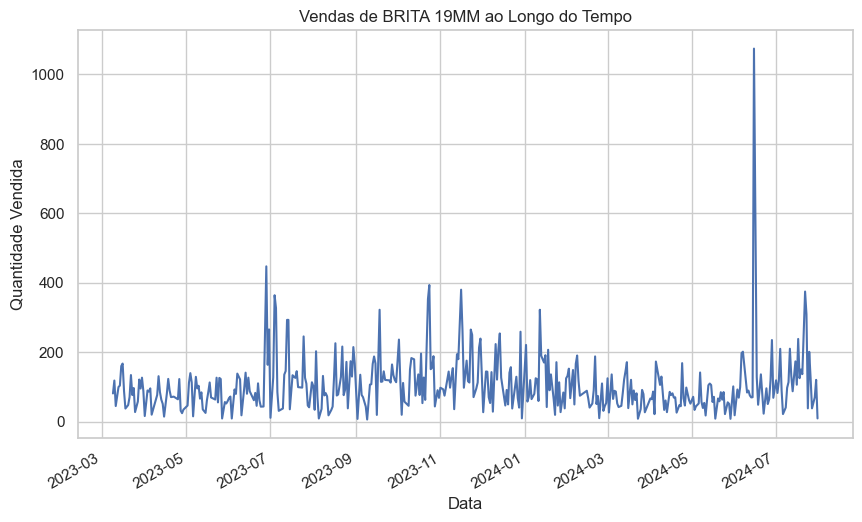

In [37]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 19MM'
vendas_produto_especifico = df_grouped[df_grouped['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))
vendas_produto_especifico.plot()
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.show()

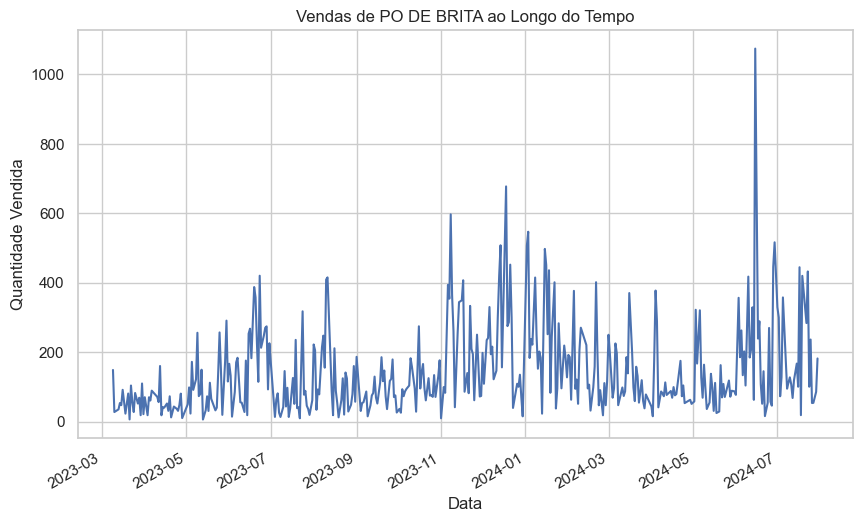

In [38]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'PO DE BRITA'
vendas_produto_especifico = df_grouped[df_grouped['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))
vendas_produto_especifico.plot()
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.show()


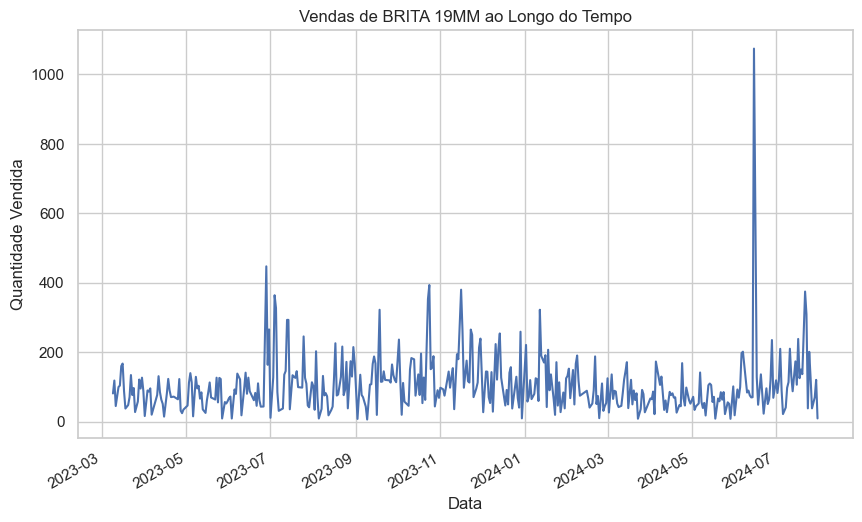

In [39]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 19MM'
vendas_produto_especifico = df_grouped[df_grouped['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))
vendas_produto_especifico.plot()
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.show()


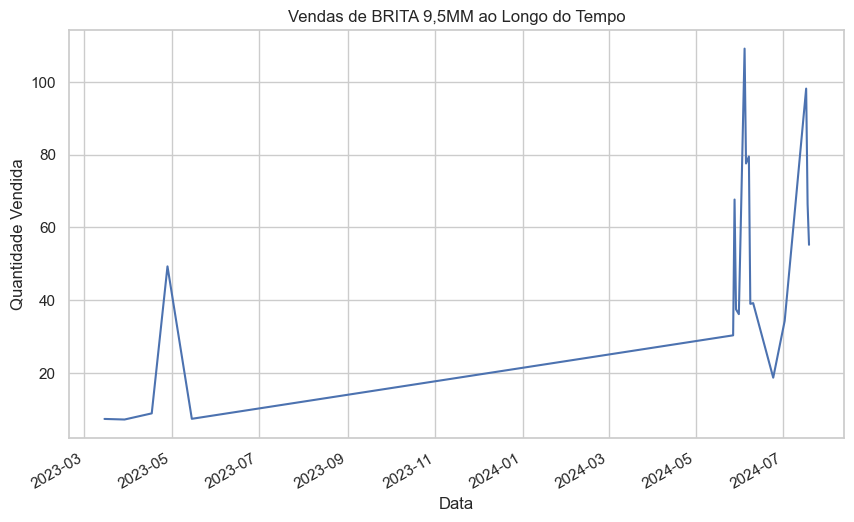

In [40]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 9,5MM'
vendas_produto_especifico = df_grouped[df_grouped['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))
vendas_produto_especifico.plot()
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.show()


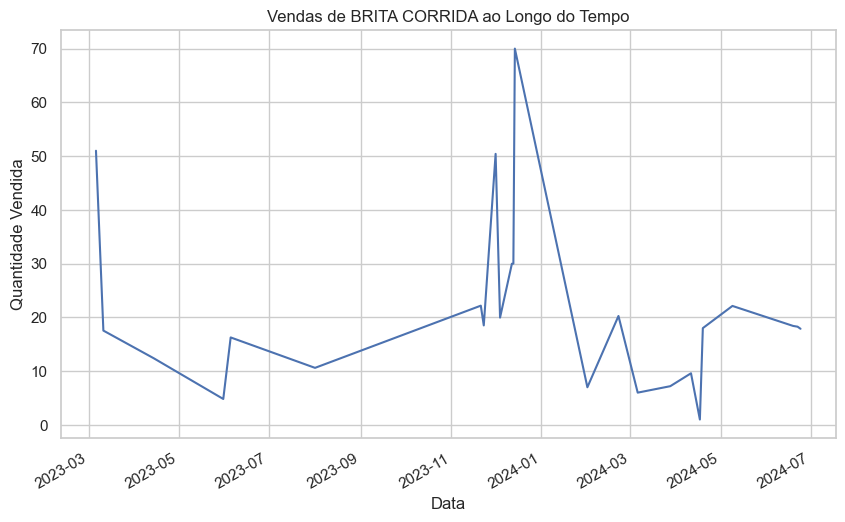

In [41]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA CORRIDA'
vendas_produto_especifico = df_grouped[df_grouped['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))
vendas_produto_especifico.plot()
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.show()


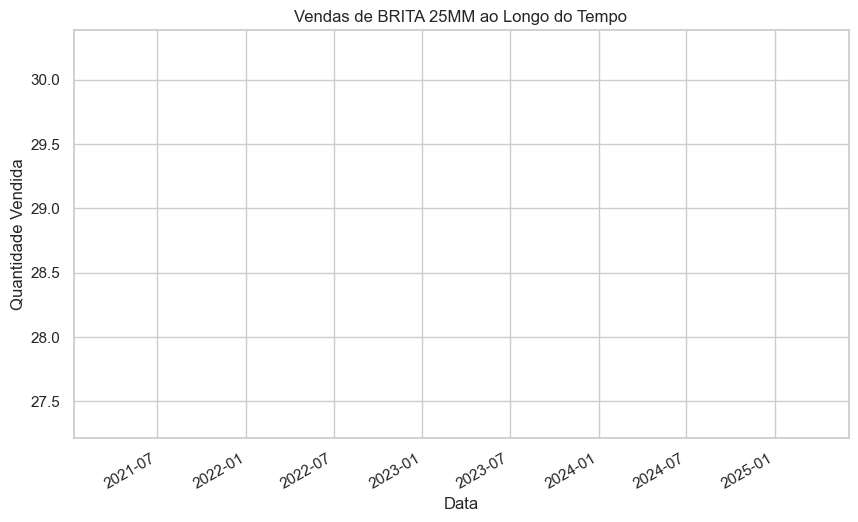

In [42]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 25MM'
vendas_produto_especifico = df_grouped[df_grouped['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))
vendas_produto_especifico.plot()
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.show()

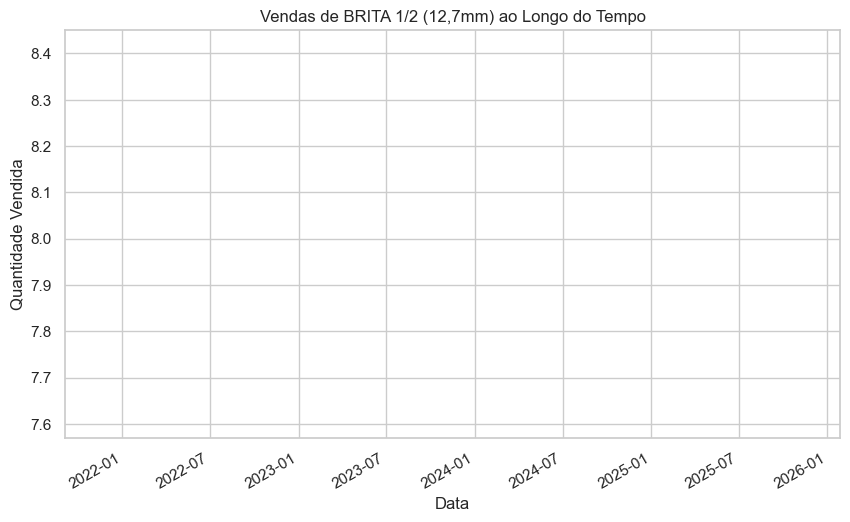

In [43]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 1/2 (12,7mm)'
vendas_produto_especifico = df_grouped[df_grouped['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))
vendas_produto_especifico.plot()
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.show()

In [44]:
# Lista de todas as datas do intervalo de vendas
date_range = pd.date_range(start=df_grouped['data_da_venda'].min(), 
                           end=df_grouped['data_da_venda'].max(), freq='D')

# Lista de todos os produtos únicos
all_products = df_grouped['produto'].unique()

# Criar um MultiIndex com todas as combinações de data e produto
index = pd.MultiIndex.from_product([date_range, all_products], names=['data_da_venda', 'produto'])

# Reindexar o DataFrame original para garantir que todas as combinações de data e produto existam
df_full = df_grouped.set_index(['data_da_venda', 'produto']).reindex(index, fill_value=0).reset_index()

# Verificar o resultado
print(df_full.head(20))

   data_da_venda             produto  quantidade
0     2023-03-01        BRITA 12,5MM        6.71
1     2023-03-01       BRITA CORRIDA        0.00
2     2023-03-01          BRITA 19MM        0.00
3     2023-03-01         PO DE BRITA        0.00
4     2023-03-01         BRITA 9,5MM        0.00
5     2023-03-01          BRITA 25MM        0.00
6     2023-03-01  BRITA 1/2 (12,7mm)        0.00
7     2023-03-02        BRITA 12,5MM        0.00
8     2023-03-02       BRITA CORRIDA        0.00
9     2023-03-02          BRITA 19MM        0.00
10    2023-03-02         PO DE BRITA        0.00
11    2023-03-02         BRITA 9,5MM        0.00
12    2023-03-02          BRITA 25MM        0.00
13    2023-03-02  BRITA 1/2 (12,7mm)        0.00
14    2023-03-03        BRITA 12,5MM        0.00
15    2023-03-03       BRITA CORRIDA        0.00
16    2023-03-03          BRITA 19MM        0.00
17    2023-03-03         PO DE BRITA        0.00
18    2023-03-03         BRITA 9,5MM        0.00
19    2023-03-03    

In [45]:
df_full.shape

(3633, 3)

In [46]:
df_full.head()

,data_da_venda,produto,quantidade
0,2023-03-01,"BRITA 12,5MM",6.71
1,2023-03-01,BRITA CORRIDA,0.00
2,2023-03-01,BRITA 19MM,0.00
3,2023-03-01,PO DE BRITA,0.00
4,2023-03-01,"BRITA 9,5MM",0.00


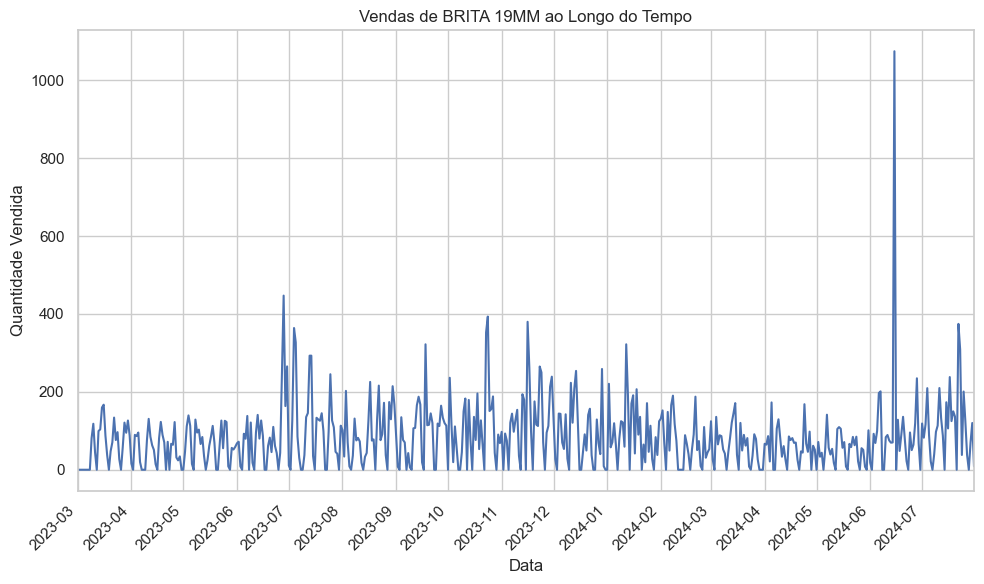

In [47]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 19MM'
vendas_produto_especifico = df_full[df_full['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))

# Plotar o gráfico
vendas_produto_especifico.plot()

# Formatar o eixo x para mostrar as datas no formato 'YYYY-MM'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Ajustar o intervalo das datas no eixo x para melhorar a visualização
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Título e rótulos
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

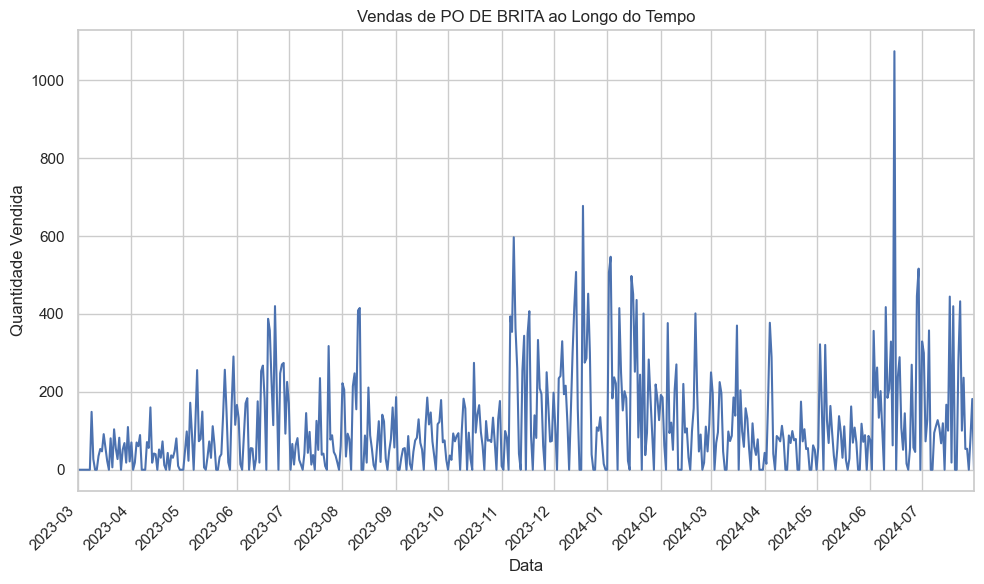

In [48]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'PO DE BRITA'
vendas_produto_especifico = df_full[df_full['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))

# Plotar o gráfico
vendas_produto_especifico.plot()

# Formatar o eixo x para mostrar as datas no formato 'YYYY-MM'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Ajustar o intervalo das datas no eixo x para melhorar a visualização
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Título e rótulos
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

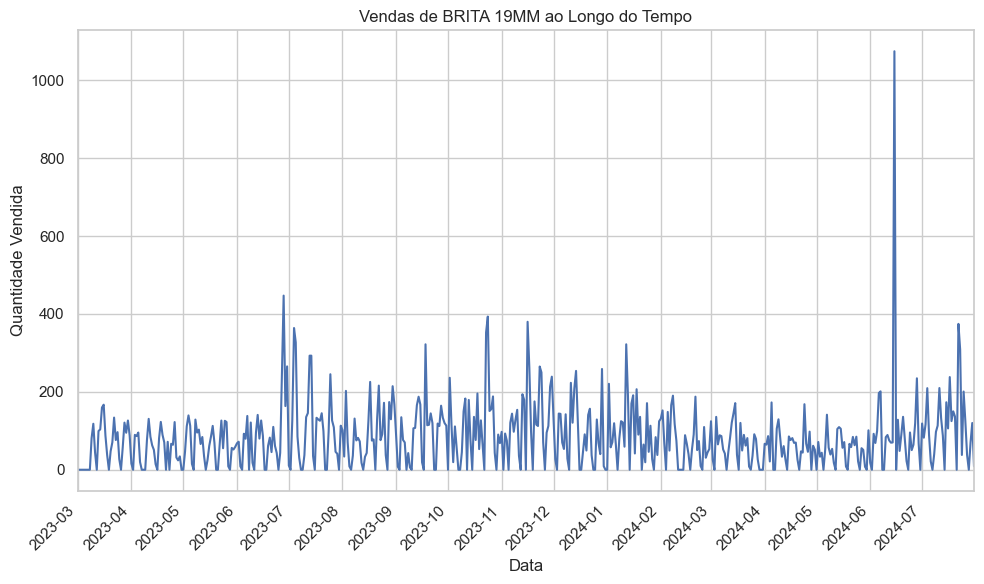

In [49]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 19MM'
vendas_produto_especifico = df_full[df_full['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))

# Plotar o gráfico
vendas_produto_especifico.plot()

# Formatar o eixo x para mostrar as datas no formato 'YYYY-MM'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Ajustar o intervalo das datas no eixo x para melhorar a visualização
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Título e rótulos
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

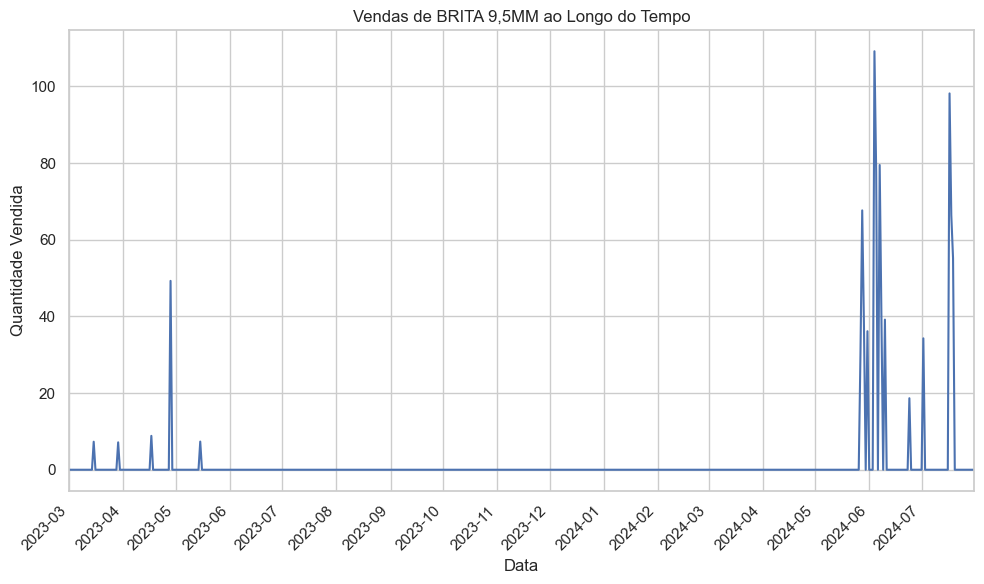

In [50]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 9,5MM'
vendas_produto_especifico = df_full[df_full['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))

# Plotar o gráfico
vendas_produto_especifico.plot()

# Formatar o eixo x para mostrar as datas no formato 'YYYY-MM'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Ajustar o intervalo das datas no eixo x para melhorar a visualização
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Título e rótulos
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

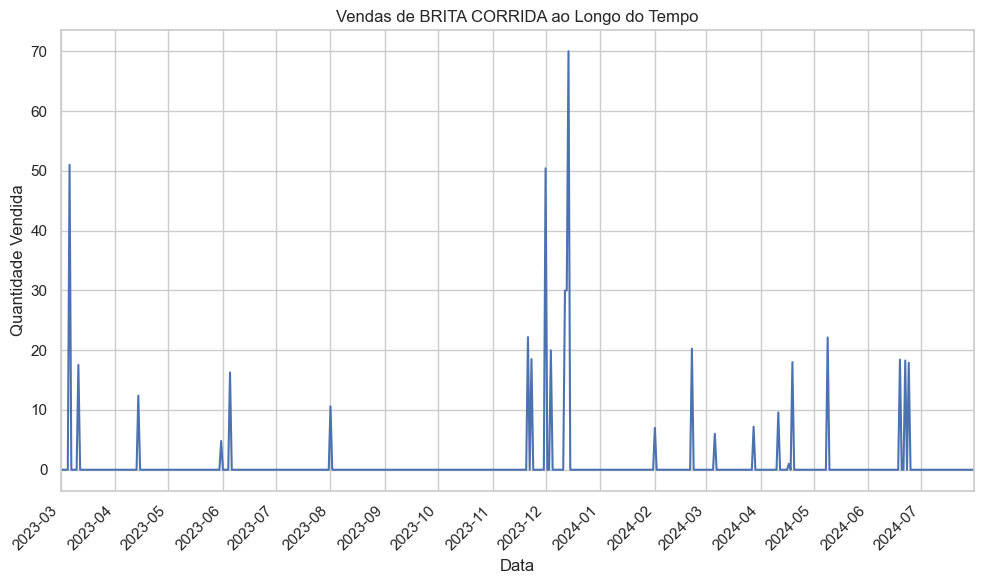

In [51]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA CORRIDA'
vendas_produto_especifico = df_full[df_full['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))

# Plotar o gráfico
vendas_produto_especifico.plot()

# Formatar o eixo x para mostrar as datas no formato 'YYYY-MM'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Ajustar o intervalo das datas no eixo x para melhorar a visualização
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Título e rótulos
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

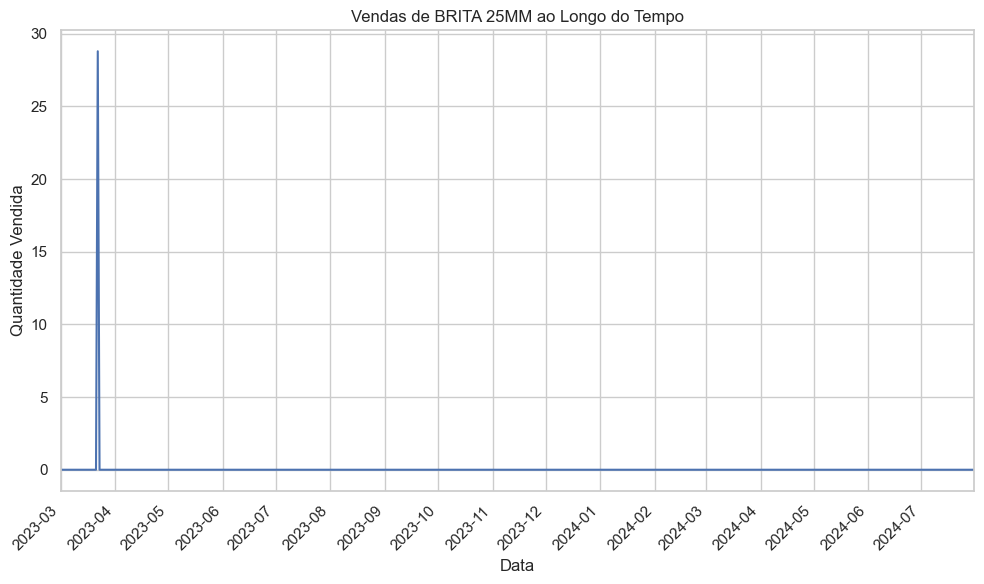

In [52]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 25MM'
vendas_produto_especifico = df_full[df_full['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))

# Plotar o gráfico
vendas_produto_especifico.plot()

# Formatar o eixo x para mostrar as datas no formato 'YYYY-MM'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Ajustar o intervalo das datas no eixo x para melhorar a visualização
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Título e rótulos
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

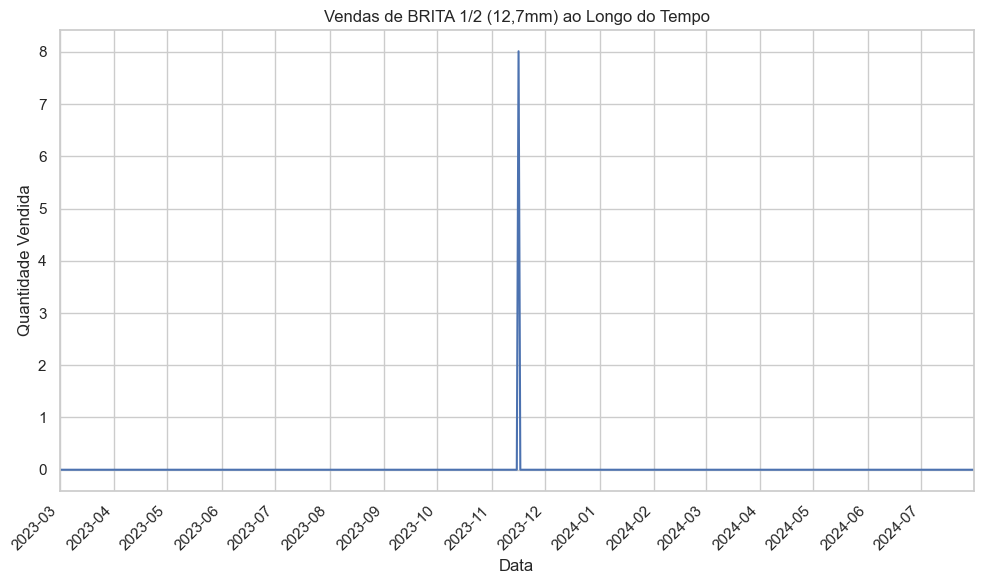

In [53]:
# Escolher um produto para analisar as vendas ao longo do tempo
produto_especifico = 'BRITA 1/2 (12,7mm)'
vendas_produto_especifico = df_full[df_full['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()

# Plotar as vendas do produto específico ao longo do tempo
plt.figure(figsize=(10, 6))

# Plotar o gráfico
vendas_produto_especifico.plot()

# Formatar o eixo x para mostrar as datas no formato 'YYYY-MM'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Ajustar o intervalo das datas no eixo x para melhorar a visualização
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Título e rótulos
plt.title(f'Vendas de {produto_especifico} ao Longo do Tempo')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

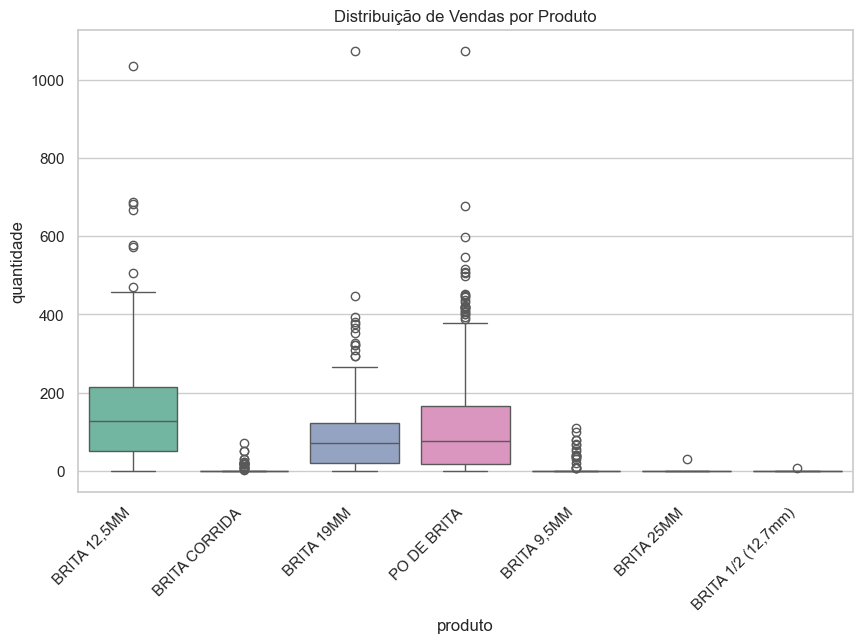

In [54]:
# Boxplot para verificar outliers nas vendas por produto
plt.figure(figsize=(10, 6))
sns.boxplot(x='produto', y='quantidade', data=df_full, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Distribuição de Vendas por Produto')
plt.show()

### Suavização com Média Móvel

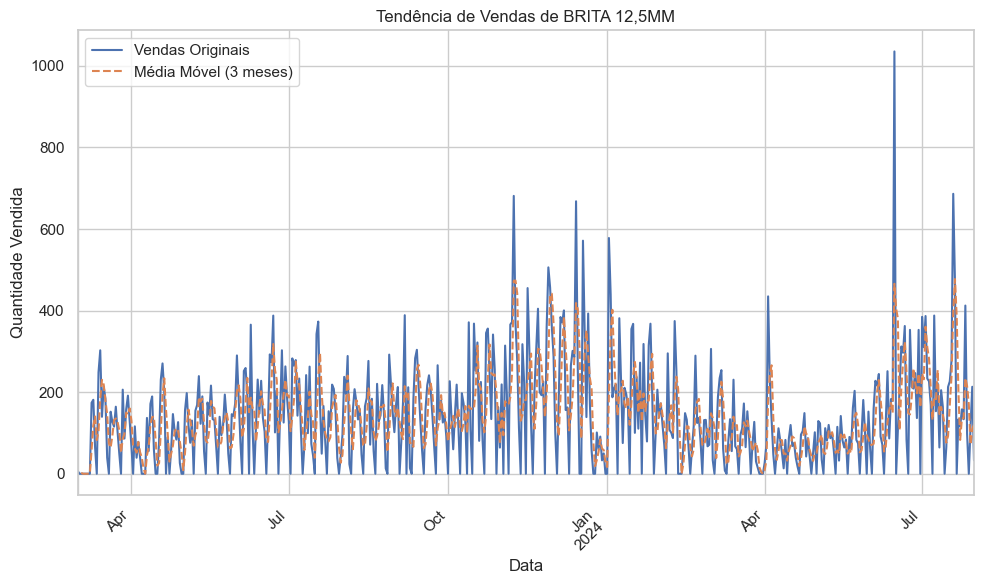

In [55]:
# Aplicar média móvel de 3 meses para suavizar a série
produto_especifico = 'BRITA 12,5MM'
vendas_produto_especifico = df_full[df_full['produto'] == produto_especifico].groupby('data_da_venda')['quantidade'].sum()
vendas_suavizadas = vendas_produto_especifico.rolling(window=3).mean()

# Plotar a série original e suavizada
plt.figure(figsize=(10, 6))
vendas_produto_especifico.plot(label='Vendas Originais')
vendas_suavizadas.plot(label='Média Móvel (3 meses)', linestyle='--')
plt.title(f'Tendência de Vendas de {produto_especifico}')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Data')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4.1. Analise Univariada

**Como é essa variavel?** (min, max, range, distribuição...)

## 4.2. Analise Bivariada

**Como a variavel impacta na resposta?** (correlação, validação das impoteses..)

## 4.3. Analise Multivariada

**Como as variaveis se relacionam?** (qual a correlação entre elas?)

#  5.0. - DATA PREPARATION

In [57]:
df5 = df_full.copy()

In [58]:
df5.head()

,data_da_venda,produto,quantidade
0,2023-03-01,"BRITA 12,5MM",6.71
1,2023-03-01,BRITA CORRIDA,0.00
2,2023-03-01,BRITA 19MM,0.00
3,2023-03-01,PO DE BRITA,0.00
4,2023-03-01,"BRITA 9,5MM",0.00


In [59]:
df5.shape

(3633, 3)

## 5.1. Normalizacao

**Rescala o centro para 0 com o desvio padrão igual a 1**

## 5.2. Rescaling

**Rescala para o intervalo entre 0 e 1**

**Distruição gaussiana**

## 5.3. Transformacao

**Conversão de features categoricas para numericas (encoding)**

**Transformação de natureza**

# 6.0 FEATURE SELECTION

**A explicação mais simples sobre um fenomeno observado, deveria prevalecer sobre explicações mais complexas.**

**Dê sempre preferência para o mais simples**

**Variáveis Colineares**

In [60]:
df6 = df5.copy()

# 7.0. MACHINE LEARNING MODELLING

Machine Learning (ML) é um subcampo da Inteligência Artificial (IA) que envolve o desenvolvimento de algoritmos que permitem aos computadores aprenderem a partir de dados, sem a necessidade de serem explicitamente programados para cada tarefa. Em vez de seguirem uma sequência de comandos rígidos, os modelos de aprendizado de máquina analisam dados, reconhecem padrões e fazem previsões ou tomam decisões com base nessas informações.

**Tarefas principais do Machine Learning**
Existem várias tarefas de machine learning, cada uma voltada para resolver diferentes tipos de problemas. As mais comuns incluem aprendizado supervisionado, aprendizado não supervisionado, aprendizado por reforço e aprendizado semi-supervisionado.

1. **Aprendizado Supervisionado**
   
No aprendizado supervisionado, o modelo é treinado com um conjunto de dados rotulados, onde cada entrada tem uma saída conhecida. O objetivo é aprender a mapear entradas (features) para saídas (rótulos) de modo a prever a saída correta para novos dados.

* **Tarefa: Classificação**
A classificação visa atribuir a uma entrada um rótulo ou categoria. Exemplos incluem:

**Exemplo:** Classificação de e-mails como spam ou não spam. O modelo é treinado com e-mails rotulados como spam ou não spam e, com base em características como palavras-chave, ele aprende a identificar novos e-mails.

![texto alternativo](images/3.png)

* **Tarefa: Regressão**
A regressão prevê um valor numérico contínuo.

**Exemplo:** Prever o preço de casas com base em dados como metragem quadrada, localização e número de quartos.

![texto alternativo](images/4.png)

2. **Aprendizado Não Supervisionado**
Aqui, o modelo é treinado sem rótulos de saída. O objetivo é encontrar padrões ou estruturas ocultas nos dados.

**Tarefa: Agrupamento (Clustering)**
O agrupamento consiste em dividir dados em grupos ou clusters com características semelhantes.

**Exemplo:** Agrupar clientes de uma loja com base em comportamento de compra. Isso pode ajudar a criar campanhas de marketing mais direcionadas.

![texto alternativo](images/5.png)

**Séries temporais** são uma sequência de dados que são coletados ou registrados em intervalos de tempo específicos. Esses dados possuem uma dependência temporal, ou seja, os valores passados influenciam os valores futuros, e o objetivo é analisar ou prever comportamentos futuros com base em padrões temporais passados.

**Características principais de séries temporais:**
Dependência temporal: Os dados em séries temporais seguem uma ordem específica no tempo. Um valor em um determinado ponto no tempo pode depender de valores anteriores ou até mesmo futuros.

**Exemplo:** As vendas de um produto no mês de janeiro podem influenciar as vendas em fevereiro e março.

In [61]:
df7 = df6.copy()

**Modelos Estatísticos Clássicos:** Modelos como ARIMA e SARIMA são baseados em pressupostos estatísticos e padrões lineares. Eles analisam a série temporal para encontrar tendências, sazonalidades e padrões repetitivos.

**Exemplo:** O ARIMA (AutoRegressive Integrated Moving Average) utiliza os valores passados da série e as médias móveis para prever valores futuros.

Tamanho do conjunto de treinamento: 415
Tamanho do conjunto de teste: 104


D:\Anaconda\envs\projetominicurso3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\projetominicurso3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 105.00352301594593
RMSE: 161.66575568534054
                 Data  Quantidade Real  Quantidade Prevista
2024-04-19 2024-04-19            39.13           109.219033
2024-04-20 2024-04-20            17.85            93.311044
2024-04-21 2024-04-21             0.00            96.713240
2024-04-22 2024-04-22            96.14            82.442726
2024-04-23 2024-04-23           104.61            46.812341


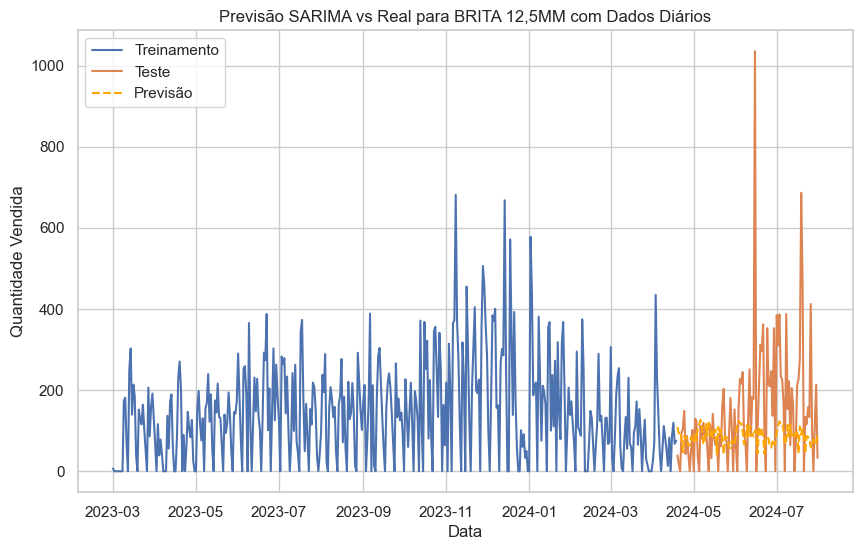

In [99]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Se a coluna já estiver no formato Period, converta para Timestamp
if isinstance(df7['data_da_venda'].dtype, pd.PeriodDtype):
    df7['data_da_venda'] = df7['data_da_venda'].dt.to_timestamp()

# Filtrar para um produto específico, por exemplo, BRITA 12,5MM
df_brita = df7[df7['produto'] == 'BRITA 12,5MM']

# Definir 'data_da_venda' como índice
df_brita = df_brita.set_index('data_da_venda')

# Adicionar variáveis de tempo: mês, dia da semana
df_brita['mes'] = df_brita.index.month
df_brita['dia_da_semana'] = df_brita.index.dayofweek

# Adicionar médias móveis e desvios padrão (rolling windows)
df_brita['rolling_mean_7'] = df_brita['quantidade'].rolling(window=7).mean()
df_brita['rolling_std_7'] = df_brita['quantidade'].rolling(window=7).std()

# Preencher NaN gerados pelas janelas móveis
df_brita = df_brita.fillna(0)

# Dividir os dados em treinamento e teste (80% para treinamento)
train_size = int(len(df_brita) * 0.8)
train, test = df_brita.iloc[:train_size], df_brita.iloc[train_size:]

# Verifique o tamanho dos conjuntos de dados
print(f'Tamanho do conjunto de treinamento: {len(train)}')
print(f'Tamanho do conjunto de teste: {len(test)}')

# Ajustar o modelo SARIMA no conjunto de treinamento
# Parâmetros (AR=1, I=1, MA=1) e sazonalidade diária (exemplo: ciclo mensal=30)
model = SARIMAX(train['quantidade'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
model_fit = model.fit(disp=False)

# Fazer a previsão para o período de teste
forecast = model_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean

# Garantir que os valores previstos não sejam negativos
forecast_values[forecast_values < 0] = 0

# Avaliar o modelo comparando as previsões com os dados reais
mae = mean_absolute_error(test['quantidade'], forecast_values)
rmse = mean_squared_error(test['quantidade'], forecast_values, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Criar um DataFrame com os valores reais e previstos
df_comparacao = pd.DataFrame({
    'Data': test.index,
    'Quantidade Real': test['quantidade'],
    'Quantidade Prevista': forecast_values
})

# Exibir os primeiros valores para visualização
print(df_comparacao.head())

# Plotar as previsões vs dados reais
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['quantidade'], label='Treinamento')
plt.plot(test.index, test['quantidade'], label='Teste')
plt.plot(test.index, forecast_values, label='Previsão', linestyle='--', color='orange')
plt.title('Previsão SARIMA vs Real para BRITA 12,5MM com Dados Diários')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.legend()
plt.show()

**Modelos de Machine Learning:** No aprendizado de máquina, algoritmos supervisionados ou não supervisionados podem ser aplicados para prever séries temporais. Eles têm mais flexibilidade para capturar padrões não lineares e interações complexas nos dados, o que é difícil com métodos estatísticos tradicionais.

**Exemplo:** Algoritmos como XGBoost, Random Forest e Redes Neurais podem ser treinados para prever séries temporais, identificando padrões mais complexos sem depender de suposições estatísticas rígidas.


Primeiras linhas de X_train:
               lag1  mes  dia_da_semana  rolling_mean_7  rolling_std_7
data_da_venda                                                         
2023-03-02     6.71    3              3             0.0            0.0
2023-03-03     0.00    3              4             0.0            0.0
2023-03-04     0.00    3              5             0.0            0.0
2023-03-05     0.00    3              6             0.0            0.0
2023-03-06     0.00    3              0             0.0            0.0

Primeiras linhas de y_train:
data_da_venda
2023-03-02    0.0
2023-03-03    0.0
2023-03-04    0.0
2023-03-05    0.0
2023-03-06    0.0
Name: quantidade, dtype: float64

Primeiras linhas de X_test:
                lag1  mes  dia_da_semana  rolling_mean_7  rolling_std_7
data_da_venda                                                          
2024-04-19     75.25    4              4       67.321429      38.137776
2024-04-20     39.13    4              5       58.030000     

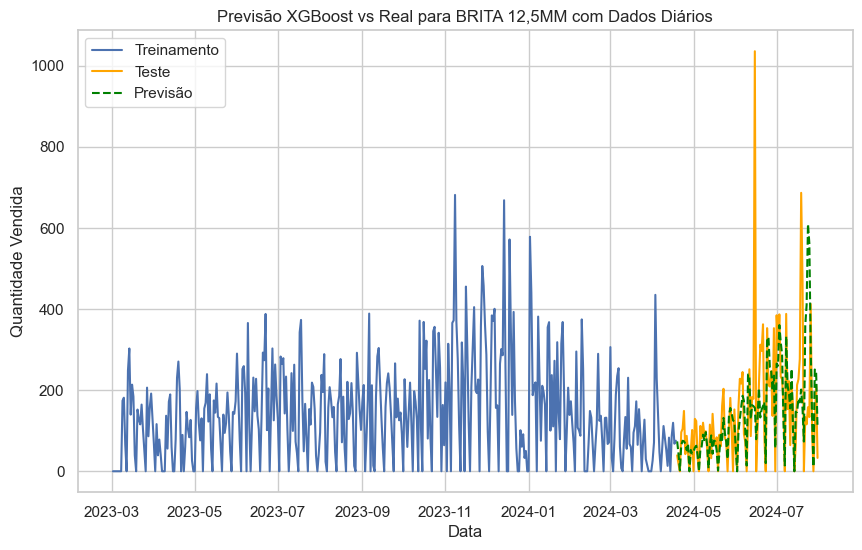

In [100]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Adicionar variáveis de tempo: mês, dia da semana
df_brita['mes'] = df_brita.index.month
df_brita['dia_da_semana'] = df_brita.index.dayofweek

# Adicionar médias móveis e desvios padrão (rolling windows)
df_brita['rolling_mean_7'] = df_brita['quantidade'].rolling(window=7).mean()
df_brita['rolling_std_7'] = df_brita['quantidade'].rolling(window=7).std()

# Preencher NaN gerados pelas janelas móveis
df_brita = df_brita.fillna(0)

# Criar lags (valores anteriores) como features para o modelo
df_brita['lag1'] = df_brita['quantidade'].shift(1)
df_brita = df_brita.dropna()  # Remover linhas com valores NaN criados pelo shift

# Dividir em features (X) e target (y)
X = df_brita[['lag1', 'mes', 'dia_da_semana', 'rolling_mean_7', 'rolling_std_7']]
y = df_brita['quantidade']

# Dividir os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Mostrar as primeiras linhas dos dados de treinamento e teste
print(f"\nPrimeiras linhas de X_train:\n{X_train.head()}")
print(f"\nPrimeiras linhas de y_train:\n{y_train.head()}")
print(f"\nPrimeiras linhas de X_test:\n{X_test.head()}")
print(f"\nPrimeiras linhas de y_test:\n{y_test.head()}")

# Treinar o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Fazer a previsão nos dados de teste
y_pred = model.predict(X_test)

# Ajustar valores negativos para zero
y_pred[y_pred < 0] = 0

# Avaliar o modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Exibir métricas de avaliação
print(f"\nMétricas de Avaliação:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Criar DataFrame com os valores reais e preditos
df_comparacao = pd.DataFrame({
    'Data': y_test.index,
    'Quantidade Real': y_test,
    'Quantidade Prevista': y_pred
})

# Exibir os primeiros valores reais e previstos
print("\nComparação de Valores Reais e Previstos:")
print(df_comparacao.head())

# Plotar os resultados (dados reais vs previsões)
plt.figure(figsize=(10, 6))

# Gráfico de treinamento
plt.plot(y_train.index, y_train, label='Treinamento')

# Gráfico de teste com dados reais
plt.plot(y_test.index, y_test, label='Teste', color='orange')

# Gráfico das previsões
plt.plot(y_test.index, y_pred, label='Previsão', linestyle='--', color='green')

# Configurações do gráfico
plt.title('Previsão XGBoost vs Real para BRITA 12,5MM com Dados Diários')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.legend()

# Mostrar o gráfico
plt.show()

# 8.0.  TRADUCAO E INTERPRETACAO DO ERRO

**Importância da Tradução e Interpretação do Erro:**
A tradução e interpretação do erro são fundamentais para entender a qualidade e o desempenho de um modelo de machine learning. Quando se constrói um modelo preditivo, o erro é o principal indicador de quão próximo o modelo está das previsões corretas ou reais. Se um modelo apresenta um erro alto, isso indica que as previsões feitas pelo modelo estão longe dos valores reais e que ele precisa ser ajustado.

**A interpretação adequada dos erros permite:**

**Avaliar a performance:** Verifica se o modelo é bom o suficiente para a tarefa desejada. Mesmo que o erro seja numérico, ele precisa ser traduzido em termos práticos, como: "quão longe estamos das vendas reais previstas?".

**Tomada de decisões:** O erro influencia ajustes no modelo, como mudança de parâmetros, escolha de diferentes algoritmos ou inclusão de novas features. Ao entender o erro, os desenvolvedores e analistas podem melhorar a precisão das previsões.

**Comparação entre modelos:** Métricas de erro permitem comparar diferentes modelos para escolher o que oferece as melhores previsões. Ao interpretar adequadamente o erro, é possível escolher o modelo que maximiza a acurácia ou minimiza o erro.

**Root Mean Squared Error (RMSE)**

O Root Mean Squared Error (RMSE) é uma métrica utilizada para medir o erro entre os valores preditos por um modelo e os valores reais observados. Ele fornece uma ideia da magnitude dos erros que o modelo está cometendo em relação ao valor real.

**Fórmula:**

![texto alternativo](images/6.png)

**Interpretação**

* O RMSE é uma medida de dispersão dos resíduos ou erros. Ele mostra o desvio padrão dos erros, ou seja, quanto as previsões estão afastadas dos valores reais em média.

* Como a fórmula envolve a raiz quadrada, ele penaliza os grandes erros de forma mais significativa. Isso significa que valores grandes de erro terão um impacto maior no cálculo do RMSE, tornando-o sensível a outliers.

* Quanto menor o RMSE, melhor o modelo. No entanto, ele não tem uma unidade interpretável, então deve ser comparado diretamente com a métrica ou outras previsões.

**Mean Absolute Error (MAE)**

O Mean Absolute Error (MAE) é outra métrica de avaliação que calcula a média dos erros absolutos entre as previsões e os valores reais. Ao contrário do RMSE, ele simplesmente soma os erros absolutos sem elevar ao quadrado, o que o torna menos sensível a grandes erros.

**Fórmula:**

![texto alternativo](images/7.png)

**Interpretação:**

* O MAE indica o erro médio que o modelo está cometendo sem penalizar grandes erros de forma desproporcional. Ele mede o quão distante, em média, as previsões estão dos valores reais.

* Menor MAE significa que o modelo é mais preciso, pois há menos erros médios nas previsões.

* Ao contrário do RMSE, o MAE preserva a unidade dos dados originais, o que facilita a interpretação. Por exemplo, se o MAE é 10 unidades de venda, significa que, em média, o modelo erra por 10 unidades.

**Exemplos:**

Se estivermos prevendo as vendas de um produto e nosso RMSE for de 50 unidades e o MAE for de 30 unidades, podemos interpretar assim:

* O RMSE de 139 indica que, em média, nossos erros têm um desvio de 139 unidades das vendas reais, mas há uma penalização maior para grandes erros.

* O MAE de 75 significa que, em média, o modelo erra em 75 unidades de venda em suas previsões.

# 9.0. Utilização


Previsão para os próximos 90 dias:
         Data  Quantidade Prevista
0  2024-08-01            63.446468
1  2024-08-02             0.000000
2  2024-08-03            45.324997
3  2024-08-04           490.890930
4  2024-08-05             0.000000
..        ...                  ...
85 2024-10-25           188.476837
86 2024-10-26           185.152557
87 2024-10-27             0.000000
88 2024-10-28            20.371471
89 2024-10-29           306.016998

[90 rows x 2 columns]


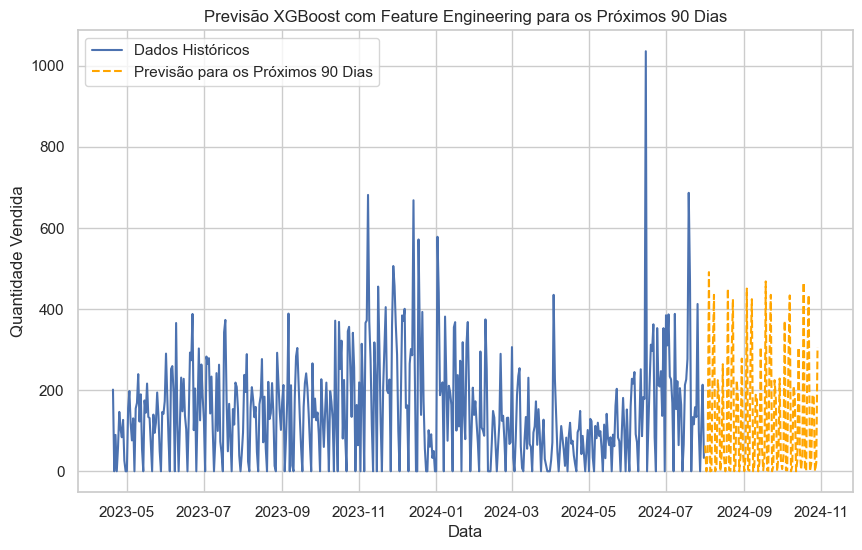

In [94]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adicionar variáveis de tempo: mês, dia da semana
df_brita['mes'] = df_brita.index.month
df_brita['dia_da_semana'] = df_brita.index.dayofweek

# Adicionar médias móveis e desvios padrão (rolling windows)
df_brita['rolling_mean_7'] = df_brita['quantidade'].rolling(window=7).mean()
df_brita['rolling_std_7'] = df_brita['quantidade'].rolling(window=7).std()

# Preencher NaN gerados pelas janelas móveis
df_brita = df_brita.fillna(0)

# Criar lags (valores anteriores)
df_brita['lag1'] = df_brita['quantidade'].shift(1)
df_brita['lag2'] = df_brita['quantidade'].shift(2)
df_brita['lag3'] = df_brita['quantidade'].shift(3)
df_brita = df_brita.dropna()  # Remover linhas com valores NaN criados pelo shift

# Dividir em features (X) e target (y)
X = df_brita[['lag1', 'lag2', 'lag3', 'mes', 'dia_da_semana', 'rolling_mean_7', 'rolling_std_7']]
y = df_brita['quantidade']

# Treinar o modelo XGBoost com todos os dados disponíveis
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X, y)

# Iniciar a previsão para os próximos 90 dias
# Vamos começar a previsão com as últimas linhas do conjunto de dados atual
last_values = X.iloc[-1].values.reshape(1, -1)  # Últimos valores das features
forecast_values = []

# Prever para os próximos 90 dias
for i in range(90):
    # Fazer a previsão
    next_value = model.predict(last_values)[0]
    
    # Garantir que o valor não seja negativo
    next_value = max(0, next_value)
    
    # Armazenar a previsão
    forecast_values.append(next_value)
    
    # Atualizar as features (lags) para a próxima previsão
    new_row = np.roll(last_values, -3)  # Deslocar os lags
    new_row[0, -7] = (last_values[0, -7] + next_value) / 2  # Atualizar rolling_mean_7
    new_row[0, -6] = np.std([next_value, last_values[0, -6]])  # Atualizar rolling_std_7
    new_row[0, 0] = next_value  # Atualizar lag1
    new_row[0, 1] = last_values[0, 0]  # Atualizar lag2
    new_row[0, 2] = last_values[0, 1]  # Atualizar lag3

    last_values = new_row  # Atualizar para a próxima previsão

# Criar um índice de datas para os próximos 90 dias
last_date = df_brita.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=90, freq='D')

# Criar DataFrame com as previsões
df_forecast = pd.DataFrame({
    'Data': forecast_dates,
    'Quantidade Prevista': forecast_values
})

# Exibir as previsões
print("\nPrevisão para os próximos 90 dias:")
print(df_forecast)

# Plotar os valores reais e as previsões
plt.figure(figsize=(10, 6))

# Plotar os dados históricos
plt.plot(df_brita.index, df_brita['quantidade'], label='Dados Históricos')

# Plotar as previsões para os próximos 90 dias
plt.plot(df_forecast['Data'], df_forecast['Quantidade Prevista'], label='Previsão para os Próximos 90 Dias', linestyle='--', color='orange')

# Configurar o gráfico
plt.title('Previsão XGBoost com Feature Engineering para os Próximos 90 Dias')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.legend()

# Mostrar o gráfico
plt.show()


In [98]:
# Somar todos os valores da coluna 'Quantidade Prevista'
total_quantidade_prevista = df_forecast['Quantidade Prevista'].sum()
print(f"Total da Quantidade Prevista para BRITA 12,5MM (90 dias): {total_quantidade_prevista}")

Total da Quantidade Prevista para BRITA 12,5MM (90 dias): 11829.855683624744


# CRISP

![texto alternativo](images/2.png)